# Lstm video classification

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## Preparation of datas

This part is identical between the attention-based method and the LSTM method

In [2]:
def extract_label_from_filename(folder_name):
    parts = folder_name.split('-')
    emotion_id = int(parts[2])
    return emotion_id - 1  # 0-indexed labels

In [3]:
class RAVDESSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.sequences = []
        self.labels = []
        self.transform = transform

        for actor_folder in os.listdir(root_dir):
            actor_path = os.path.join(root_dir, actor_folder)
            for sequence_folder in os.listdir(actor_path):
                sequence_path = os.path.join(actor_path, sequence_folder)
                images = sorted([os.path.join(sequence_path, f) for f in os.listdir(sequence_path) if f.endswith('.png')])

                self.sequences.append(images[:60])  # truncates or pads to 60 frames
                self.labels.append(extract_label_from_filename(sequence_folder))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        imgs = []

        for img_path in sequence:
            img = plt.imread(img_path)
            if self.transform:
                img = self.transform(img)
            imgs.append(img)

        return torch.stack(imgs), torch.tensor(label)


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64))
])

dataset = RAVDESSDataset(root_dir='Projet_EADIR/img_data', transform=transform)
train_data, val_data = train_test_split(dataset, test_size=0.2, stratify=dataset.labels)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

## Model LSTM

In [5]:
# Create or overwrite log file
os.makedirs("LSTM_EADIR_Result", exist_ok=True)
with open("LSTM_EADIR_Result/results_LSTM.txt", "w") as f:
    pass  

In [6]:
class LSTMClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # (B*T, 3, 64, 64) -> (B*T, 16, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),                            # -> (B*T, 16, 32, 32)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                            # -> (B*T, 32, 16, 16)
        )
        self.lstm = nn.LSTM(input_size=32*16*16, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):  # x : (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.cnn(x)              # (B*T, 32, 16, 16)
        x = x.view(B, T, -1)         # (B, T, 8192)
        out, _ = self.lstm(x)
        out = out[:, -1, :]          # Last time exit
        return self.fc(out)

In [7]:
model = LSTMClassifier(hidden_size=128, num_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0, 0
    for X, y in train_loader:
        outputs = model(X)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == y).sum().item()
    acc = correct / len(train_loader.dataset)
    train_losses.append(running_loss)
    train_acc.append(acc)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == y).sum().item()
    val_losses.append(val_loss)
    val_acc.append(val_correct / len(val_loader.dataset))
    
    log_line = (
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Train_Loss: {running_loss:.2f}, Train_Acc: {acc:.2f}, "
        f"Val_Loss: {val_loss:.2f}, Val_Acc: {val_correct / len(val_loader.dataset):.2f}"
    )
    
    print(log_line)
    
    with open("LSTM_EADIR_Result/results_LSTM.txt", "a") as f:
        f.write(log_line + "\n")

Epoch 1/30, Train_Loss: 126.07, Train_Acc: 0.12, Val_Loss: 30.75, Val_Acc: 0.17
Epoch 2/30, Train_Loss: 121.35, Train_Acc: 0.20, Val_Loss: 32.13, Val_Acc: 0.17
Epoch 3/30, Train_Loss: 113.31, Train_Acc: 0.25, Val_Loss: 28.43, Val_Acc: 0.23
Epoch 4/30, Train_Loss: 108.71, Train_Acc: 0.31, Val_Loss: 26.58, Val_Acc: 0.26
Epoch 5/30, Train_Loss: 101.69, Train_Acc: 0.36, Val_Loss: 27.44, Val_Acc: 0.24
Epoch 6/30, Train_Loss: 97.20, Train_Acc: 0.36, Val_Loss: 26.06, Val_Acc: 0.38
Epoch 7/30, Train_Loss: 94.12, Train_Acc: 0.42, Val_Loss: 23.42, Val_Acc: 0.40
Epoch 8/30, Train_Loss: 88.98, Train_Acc: 0.44, Val_Loss: 25.06, Val_Acc: 0.39
Epoch 9/30, Train_Loss: 93.73, Train_Acc: 0.40, Val_Loss: 22.57, Val_Acc: 0.38
Epoch 10/30, Train_Loss: 83.08, Train_Acc: 0.47, Val_Loss: 21.94, Val_Acc: 0.41
Epoch 11/30, Train_Loss: 77.51, Train_Acc: 0.54, Val_Loss: 19.43, Val_Acc: 0.47
Epoch 12/30, Train_Loss: 72.12, Train_Acc: 0.61, Val_Loss: 19.37, Val_Acc: 0.51
Epoch 13/30, Train_Loss: 66.20, Train_Acc: 0

### Saving the model

In [8]:
import os
import torch

# Create directory if it doesn't exist
result_dir = "LSTM_EADIR_Result"
os.makedirs(result_dir, exist_ok=True)

# Save the model
model_path = os.path.join(result_dir, "lstm_model.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to LSTM_EADIR_Result/lstm_model.pth


### Results

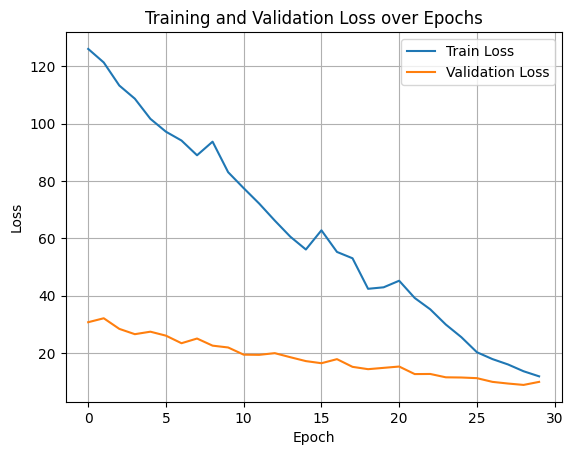

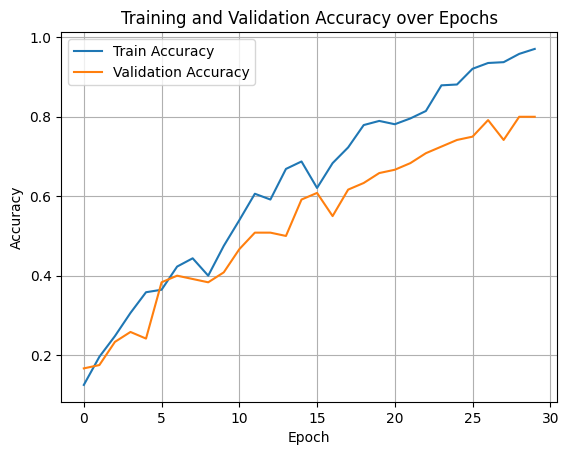

In [9]:
# Loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("LSTM_EADIR_Result/loss_curve.png")
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("LSTM_EADIR_Result/accuracy_curve.png")
plt.show()

## Evaluation

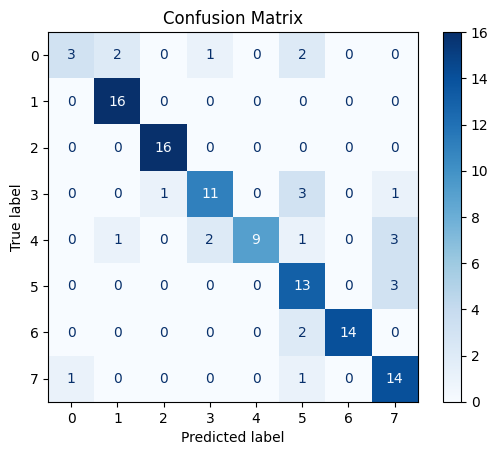

In [10]:
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        outputs = model(X)
        preds = outputs.argmax(1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("LSTM_EADIR_Result/confusion_matrix.png")
plt.show()